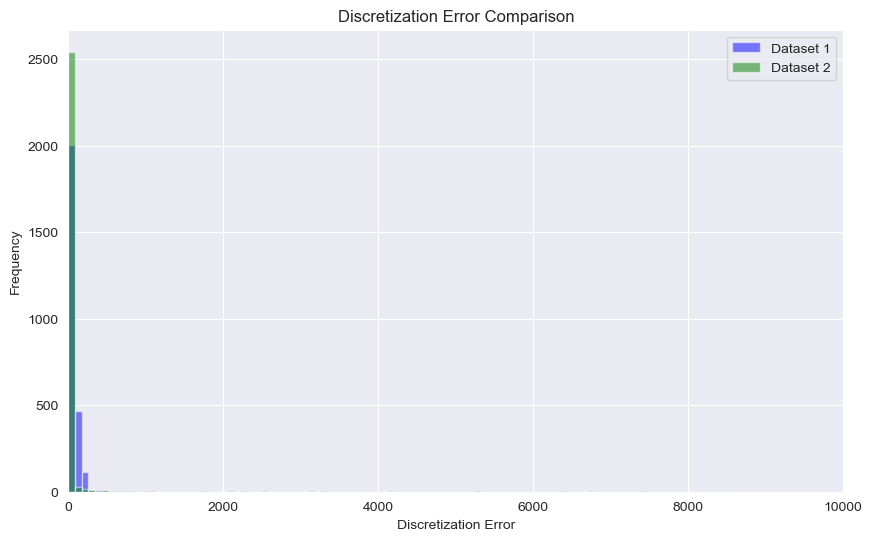

In [4]:
import numpy as np
from utils.helpers import Helpers

h = Helpers()
from utils import column_names as s
from analysis import analysis
import pandas as pd
import matplotlib.pyplot as plt

# Assuming the necessary functions and classes are imported from 'analysis' and 'h'

# First Dataset -> Hoerl
Data1 = analysis.DataframeAnalysis()
Data1.load_df_from_csv(
    r'C:\Users\petre\Documents\GitHub\MATSimPipeline\output\20250401_145600\location_assignment_result_load_intermediate_hoerl.csv')
# Data1.load_df_from_csv(r'C:\Users\petre\Documents\GitHub\MATSimPipeline\output\20250117_165311\location_assignment_result_load_intermediate_advanced_petre_70-branches_30-min-cand-two-leg_20-min-cand-complex.csv')
Data1.df = Data1.df[Data1.df['to_location'].notna()]
Data1.df = Data1.df[Data1.df['from_location'].notna()]
Data1.df['from_location'] = Data1.df['from_location'].apply(h.convert_to_point)
Data1.df['to_location'] = Data1.df['to_location'].apply(h.convert_to_point)
Data1.evaluate_distance_deviations_from_df()

# Second Dataset -> Advanced Petre 
Data2 = analysis.DataframeAnalysis()
Data2.load_df_from_csv(
    r'C:\Users\petre\Documents\GitHub\MATSimPipeline\output\20250401_151444\location_assignment_result_load_intermediate_CARLA_70-branches_30-cand-two-leg_20-min-cand-complex.csv')
#Data2.load_df_from_csv(r'C:\Users\petre\Documents\GitHub\MATSimPipeline\output\20250117_170329\location_assignment_result_load_intermediate_advanced_petre_70-branches_30-min-cand-two-leg_20-min-cand-complex.csv')
Data2.df = Data2.df[Data2.df['to_location'].notna()]
Data2.df = Data2.df[Data2.df['from_location'].notna()]
Data2.df['from_location'] = Data2.df['from_location'].apply(h.convert_to_point)
Data2.df['to_location'] = Data2.df['to_location'].apply(h.convert_to_point)
Data2.evaluate_distance_deviations_from_df()

# Ensure the maximum value is limited to 1000
# Data1.df['discretization_error'] = Data1.df['discretization_error'].clip(upper=1000)
# Data2.df['discretization_error'] = Data2.df['discretization_error'].clip(upper=1000)
# 
# Data1.df.to_csv(r"C:\Users\petre\Documents\GitHub\MATSimPipeline\output\Hoerl.csv")
# Data2.df.to_csv(r"C:\Users\petre\Documents\GitHub\MATSimPipeline\output\Petre.csv")
# # Plotting in the same plot
plt.figure(figsize=(10, 6))

# Plot histogram for Dataset 1
Data1.df['discretization_error'].plot.hist(bins=100, alpha=0.5, color='blue', label='Dataset 1')

# Plot histogram for Dataset 2
Data2.df['discretization_error'].plot.hist(bins=100, alpha=0.5, color='green', label='Dataset 2')

# Adding title and labels
plt.title('Discretization Error Comparison')
plt.xlabel('Discretization Error')
plt.ylabel('Frequency')
plt.xlim(0, 10000)
plt.legend()

plt.show()


In [5]:
# Sum up discretization errors for each person
hoerl_errors = Data1.df.groupby('unique_person_id')['discretization_error'].sum().reset_index()
hoerl_errors.rename(columns={'discretization_error': 'hoerl_error'}, inplace=True)

advanced_petre_errors = Data2.df.groupby('unique_person_id')['discretization_error'].sum().reset_index()
advanced_petre_errors.rename(columns={'discretization_error': 'advanced_petre_error'}, inplace=True)

# Merge the summed errors for comparison
merged_df = hoerl_errors.merge(advanced_petre_errors, on='unique_person_id')

# Add the error ratio column
merged_df['error_ratio'] = merged_df['advanced_petre_error'] / merged_df['hoerl_error']

# Filter for cases where advanced Petre has a higher error than Hoerl
worse_cases = merged_df[merged_df['advanced_petre_error'] > merged_df['hoerl_error']]
worse_cases = worse_cases.sort_values(by='error_ratio', ascending=False)

# Filter for cases where advanced Petre has a lower error than Hoerl
better_cases = merged_df[merged_df['advanced_petre_error'] < merged_df['hoerl_error']]
better_cases = better_cases.sort_values(by='error_ratio')

# Filter for cases where advanced Petre and Hoerl have equal errors
equal_cases = merged_df[merged_df['advanced_petre_error'] == merged_df['hoerl_error']]

print(f"Better cases: {len(better_cases)}")
print(f"Worse cases: {len(worse_cases)}")
print(f"Equal cases: {len(equal_cases)}")

worse_cases
# # Save the results
# worse_cases.to_csv('worse_cases.csv', index=False)
# better_cases.to_csv('better_cases.csv', index=False)
# equal_cases.to_csv('equal_cases.csv', index=False)

Better cases: 659
Worse cases: 1
Equal cases: 33


,unique_person_id,hoerl_error,advanced_petre_error,error_ratio
229,10223900_11782_10223901,106.504932,109.355674,1.026766


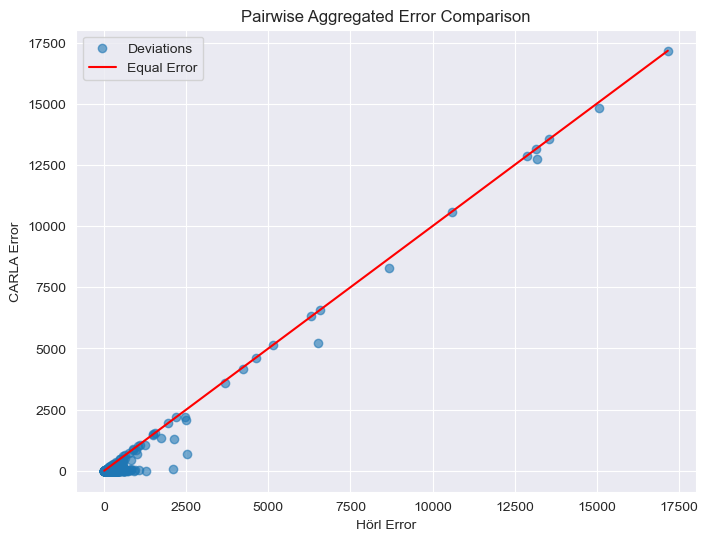

In [6]:
import matplotlib.pyplot as plt

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(merged_df['hoerl_error'], merged_df['advanced_petre_error'], alpha=0.6, label='Deviations')

# Plot the y=x line
max_val = max(merged_df['hoerl_error'].max(), merged_df['advanced_petre_error'].max())
plt.plot([0, max_val], [0, max_val], color='red', linestyle='-', label='Equal Error')

# Add labels and legend
plt.title('Pairwise Aggregated Error Comparison')
plt.xlabel('Hörl Error')
plt.ylabel('CARLA Error')
plt.legend()

# Show the plot
plt.savefig(r"C:\Users\petre\Documents\GitHub\MATSimPipeline\analysis\error_comparison_all.pdf")
plt.show()


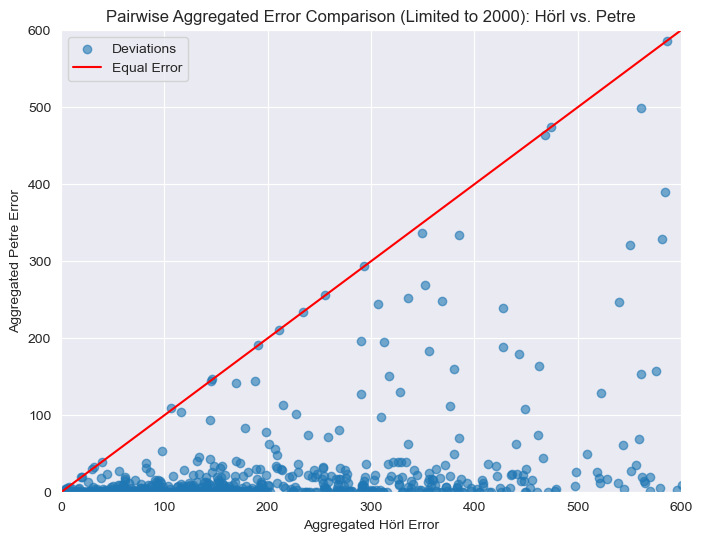

In [7]:
import matplotlib.pyplot as plt

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(merged_df['hoerl_error'], merged_df['advanced_petre_error'], alpha=0.6, label='Deviations')

# Plot the y=x line
plt.plot([0, 2000], [0, 2000], color='red', linestyle='-', label='Equal Error')

# Set axis limits
plt.xlim(0, 600)
plt.ylim(0, 600)

# Add labels and legend
plt.title('Pairwise Aggregated Error Comparison (Limited to 2000): Hörl vs. Petre')
plt.xlabel('Aggregated Hörl Error')
plt.ylabel('Aggregated Petre Error')
plt.legend()

# Show the plot
plt.savefig(r"C:\Users\petre\Documents\GitHub\MATSimPipeline\analysis\error_comparison_limited.pdf")
plt.show()


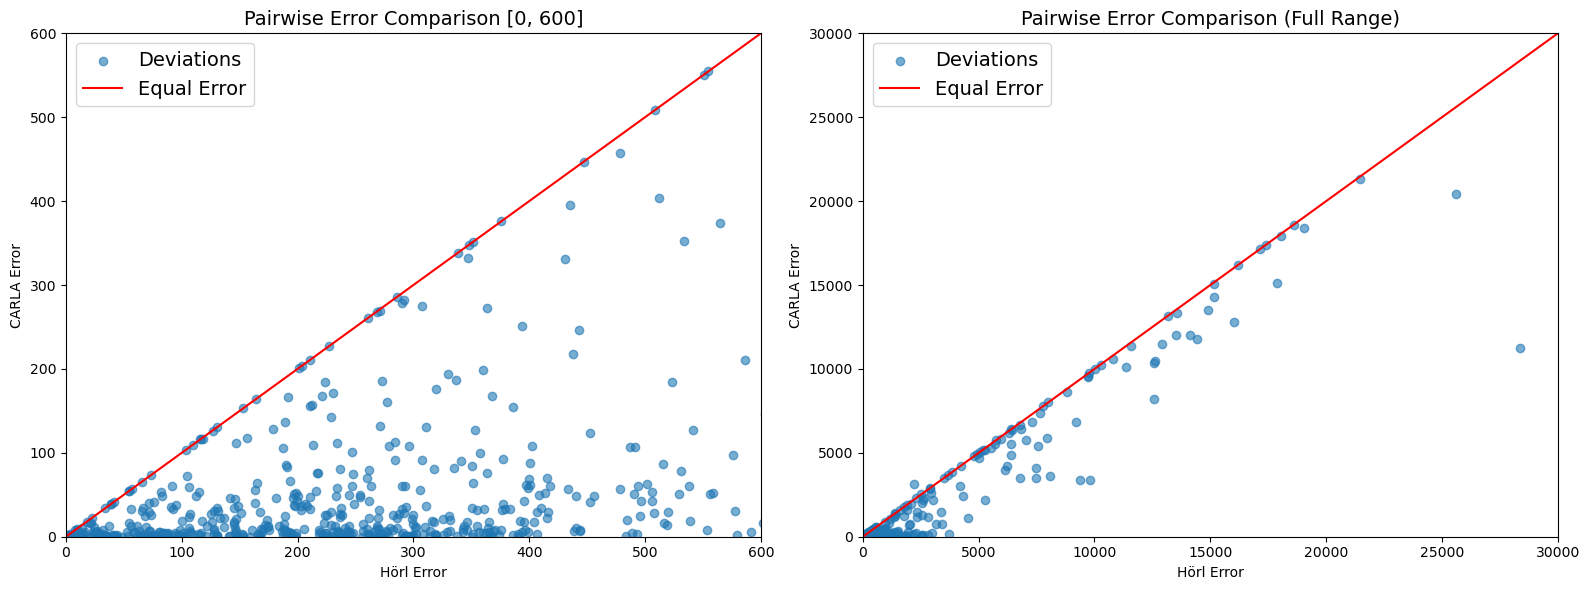

In [17]:
import matplotlib.pyplot as plt

# Create the figure
fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns

# Plot 1: Full range
axes[1].scatter(merged_df['hoerl_error'], merged_df['advanced_petre_error'], alpha=0.6, label='Deviations')
axes[1].plot([0, 30000], [0, 30000], color='red', linestyle='-', label='Equal Error')
axes[1].set_xlim(0, 30000)
axes[1].set_ylim(0, 30000)
axes[1].set_title('Pairwise Error Comparison (Full Range)', fontsize=14)
axes[1].set_xlabel('Hörl Error')
axes[1].set_ylabel('CARLA Error')
axes[1].legend(fontsize=14)
# Plot 2: Limited to 2000
axes[0].scatter(merged_df['hoerl_error'], merged_df['advanced_petre_error'], alpha=0.6, label='Deviations')
axes[0].plot([0, 600], [0, 600], color='red', linestyle='-', label='Equal Error')
axes[0].set_xlim(0, 600)
axes[0].set_ylim(0, 600)
axes[0].set_title('Pairwise Error Comparison [0, 600]', fontsize=14)
axes[0].set_xlabel('Hörl Error')
axes[0].set_ylabel('CARLA Error')
axes[0].legend(fontsize=14)

# Adjust layout and show the plots
plt.tight_layout()
plt.savefig(r"C:\Users\petre\Documents\GitHub\MATSimPipeline\analysis\error_comparison_combined.pdf")
plt.show()


In [41]:
merged_df[merged_df['advanced_petre_error'] < 20]['advanced_petre_error'].count()

287

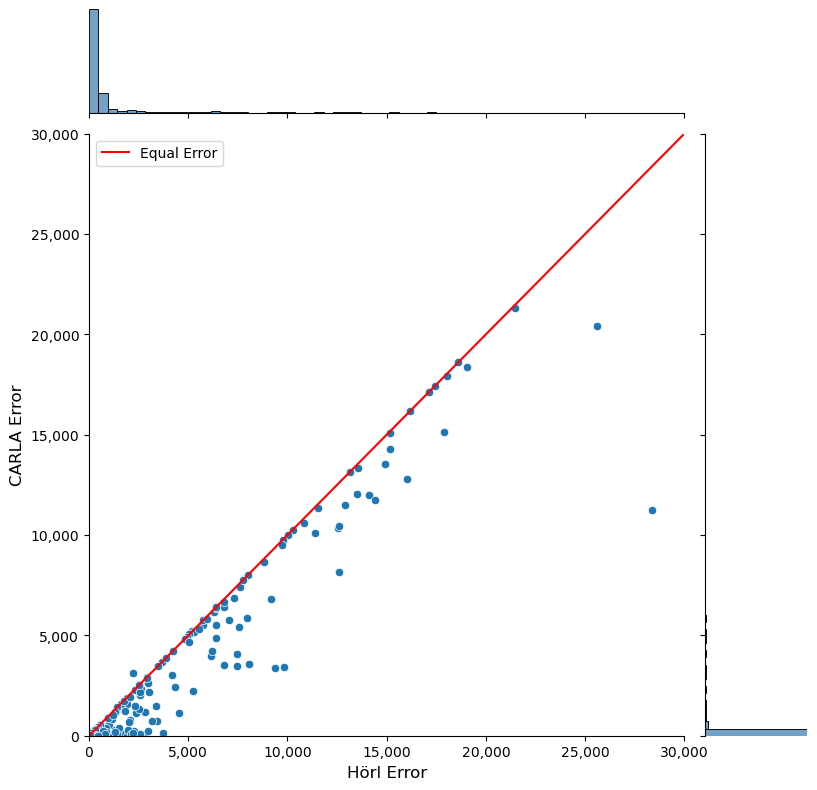

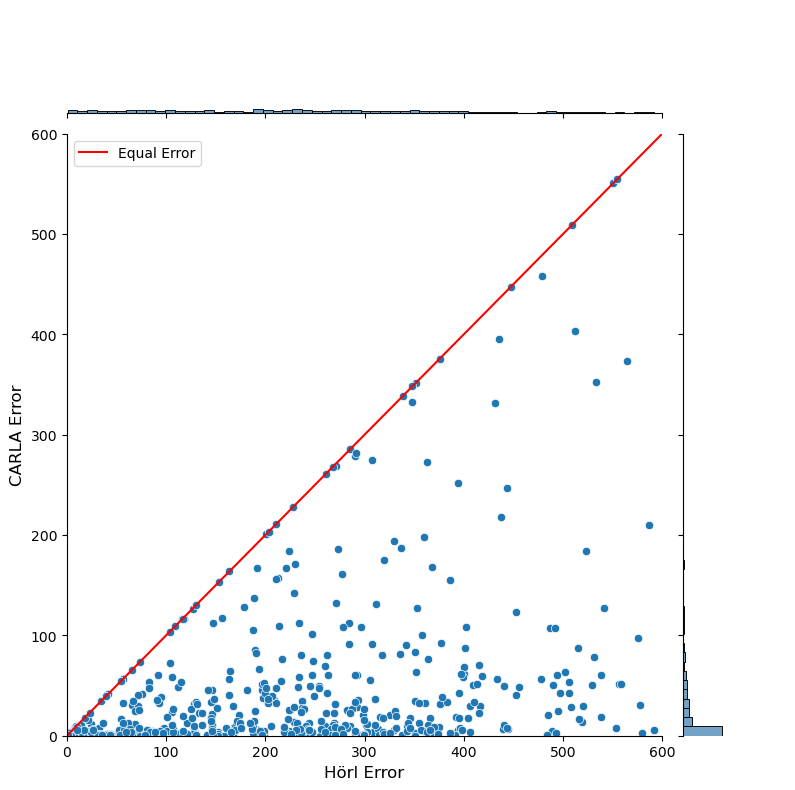

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter


# Formatter function for thousands with commas
def format_with_commas(x, _):
    return f'{x:,.0f}'


# Calculate the maximum frequency for the histograms
x_hist_max = max(
    merged_df['hoerl_error'].value_counts(bins=60).max(),
    merged_df[merged_df['hoerl_error'] < 601]['hoerl_error'].value_counts(bins=60).max()
)
y_hist_max = max(
    merged_df['advanced_petre_error'].value_counts(bins=60).max(),
    merged_df[merged_df['hoerl_error'] < 601]['advanced_petre_error'].value_counts(bins=60).max()
)

# Create the jointplot for the full range
joint1 = sns.jointplot(
    data=merged_df,
    x='hoerl_error',
    y='advanced_petre_error',
    kind='scatter',
    marginal_kws={'bins': 60, 'fill': True, 'color': 'steelblue'},
    height=8
)
joint1.ax_joint.plot([0, 30000], [0, 30000], color='red', linestyle='-', label='Equal Error')
joint1.ax_joint.legend()
joint1.ax_joint.set_xlim(0, 30000)
joint1.ax_joint.set_ylim(0, 30000)
joint1.ax_marg_x.set_ylim(0, x_hist_max)  # Set the same x-axis histogram scale
joint1.ax_marg_y.set_xlim(0, y_hist_max)  # Set the same y-axis histogram scale
joint1.ax_joint.set_xlabel('Hörl Error', fontsize=12)
joint1.ax_joint.set_ylabel('CARLA Error', fontsize=12)
joint1.ax_joint.xaxis.set_major_formatter(FuncFormatter(format_with_commas))
joint1.ax_joint.yaxis.set_major_formatter(FuncFormatter(format_with_commas))

# Create the jointplot for the limited range
joint2 = sns.jointplot(
    data=merged_df[merged_df['hoerl_error'] < 601],
    x='hoerl_error',
    y='advanced_petre_error',
    kind='scatter',
    marginal_kws={'bins': 60, 'fill': True, 'color': 'steelblue'},
    height=8
)
joint2.ax_joint.plot([0, 600], [0, 600], color='red', linestyle='-', label='Equal Error')
joint2.ax_joint.legend()
joint2.ax_joint.set_xlim(0, 600)
joint2.ax_joint.set_ylim(0, 600)
joint2.ax_marg_x.set_ylim(0, x_hist_max)  # Set the same x-axis histogram scale
joint2.ax_marg_y.set_xlim(0, y_hist_max)  # Set the same y-axis histogram scale
joint2.ax_joint.set_xlabel('Hörl Error', fontsize=12)
joint2.ax_joint.set_ylabel('CARLA Error', fontsize=12)

# Save the plots
joint1.savefig(
    r"C:\Users\petre\Documents\GitHub\MATSimPipeline\analysis\error_comparison_full_range_with_marginals_same_scale.pdf")
joint2.savefig(
    r"C:\Users\petre\Documents\GitHub\MATSimPipeline\analysis\error_comparison_limited_range_with_marginals_same_scale.pdf")

plt.show()


mean, median, plot deviation dist, the same per chain, -- capacity matching??

In [24]:
Data1.df[Data1.df["discretization_error"] < 601]

,H_ID,H_GEW,H_HOCH,MODE,BASISAUF,TEILSTP,M_CAR,H_ART,H_GR,hhgr_gr,...,home_to_main_meters,home_to_main_seconds,home_to_main_time_is_estimated,home_to_main_distance_is_estimated,to_activity_with_connected,home_location,from_location,to_location,placed_distance,discretization_error
0,10000370,0.090438,23.683802,2,2,1,0,2,2,2,...,12908.0,1050.0,1.0,1.0,leisure,[ 550137.34062287 5802360.16829969],POINT (550137.34062287 5802360.16829969),POINT (558870.52743522 5798917.56408585),9387.229393,112.770607
1,10000370,0.090438,23.683802,2,2,1,0,2,2,2,...,12908.0,1050.0,1.0,1.0,other,[ 550137.34062287 5802360.16829969],POINT (558870.52743522 5798917.56408585),POINT (558970.56679584 5799659.9773357),749.123025,399.123025
2,10000370,0.090438,23.683802,2,2,1,0,2,2,2,...,12908.0,1050.0,1.0,1.0,other,[ 550137.34062287 5802360.16829969],POINT (558970.56679584 5799659.9773357),POINT (558941.28538981 5799199.20564336),461.701151,111.701151
3,10000370,0.090438,23.683802,2,2,1,0,2,2,2,...,12908.0,1050.0,1.0,1.0,home,[ 550137.34062287 5802360.16829969],POINT (558941.28538981 5799199.20564336),POINT (550137.34062287 5802360.16829969),9354.203781,145.796219
4,10003390,1.606772,420.778622,2,2,1,0,2,2,2,...,12350.0,900.0,0.0,0.0,shopping,[ 550987.57266637 5801596.83884663],POINT (550987.57266637 5801596.83884663),POINT (554005.78989299 5802687.90889882),3209.372070,183.485073
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2658,10689840,0.661246,173.166014,2,2,1,0,2,5,5,...,10780.0,1200.0,0.0,0.0,home,[ 554699.78628227 5809800.03636093],POINT (557767.72302399 5808409.40455603),POINT (554699.78628227 5809800.03636093),3368.396157,24.460986
2659,10689840,0.661246,173.166014,2,2,1,0,2,5,5,...,12740.0,3000.0,0.0,0.0,errands,[ 547557.74049545 5806096.84598652],POINT (547557.74049545 5806096.84598652),POINT (550198.90252604 5807976.00124608),3241.444333,151.412810
2660,10689840,0.661246,173.166014,2,2,1,0,2,5,5,...,12740.0,3000.0,0.0,0.0,home,[ 547557.74049545 5806096.84598652],POINT (550198.90252604 5807976.00124608),POINT (547557.74049545 5806096.84598652),3241.444333,151.412810
2661,10689840,0.661246,173.166014,2,2,1,0,2,5,5,...,12740.0,3000.0,0.0,0.0,leisure,[ 547557.74049545 5806096.84598652],POINT (547557.74049545 5806096.84598652),POINT (556187.44522436 5808753.91633705),9029.497580,70.502420


In [25]:
Data1.df[Data1.df["discretization_error"] < 601]['unique_person_id'].nunique()


641

In [5]:
from analysis import plotting

plotting.plot_person_plan("10304630_11862_10304631", Data1.df, Data2.df)

In [5]:
Data1.df['discretization_error'].describe()

count     2663.000000
mean       378.121898
std       1148.387191
min          0.012455
25%         31.367853
50%         73.080766
75%        148.613862
max      10644.766780
Name: discretization_error, dtype: float64

In [6]:
Data2.df['discretization_error'].describe()


count     2663.000000
mean       267.555392
std       1091.745981
min          0.004719
25%          1.191919
50%          4.782691
75%         24.447311
max      10644.766780
Name: discretization_error, dtype: float64

In [211]:
# Filter df for a specific person
person_id = '10073530_11624_10073533'
person_df1 = Data1.df[Data1.df['unique_person_id'] == person_id]
person_df2 = Data2.df[Data2.df['unique_person_id'] == person_id]
person_df2

,H_ID,H_GEW,H_HOCH,MODE,BASISAUF,TEILSTP,M_CAR,H_ART,H_GR,hhgr_gr,...,home_to_main_seconds,home_to_main_time_is_estimated,home_to_main_distance_is_estimated,to_activity_with_connected,home_location,to_act_identifier,from_location,to_location,placed_distance,discretization_error
259,10073530,0.454169,118.937117,2,2,1,0,2,4,4,...,1650.0,1.0,1.0,work,[ 547230.45817282 5803523.41842474],2.379585e+08,POINT (547230.45817282 5803523.41842474),POINT (553932.79184006 5811139.34682218),10145.128976,540.585310
260,10073530,0.454169,118.937117,2,2,1,0,2,4,4,...,1650.0,1.0,1.0,return_journey,[ 547230.45817282 5803523.41842474],1.628318e+09,POINT (553932.79184006 5811139.34682218),POINT (556930.67585174 5795768.32784297),15660.636418,2260.792154
261,10073530,0.454169,118.937117,2,2,1,0,2,4,4,...,1650.0,1.0,1.0,leisure,[ 547230.45817282 5803523.41842474],8.084981e+08,POINT (556930.67585174 5795768.32784297),POINT (554461.0410041 5802100.20238781),6796.449921,39.307064
262,10073530,0.454169,118.937117,2,2,1,0,2,4,4,...,1650.0,1.0,1.0,home,[ 547230.45817282 5803523.41842474],NaN,POINT (554461.0410041 5802100.20238781),POINT (547230.45817282 5803523.41842474),7369.319641,283.605355


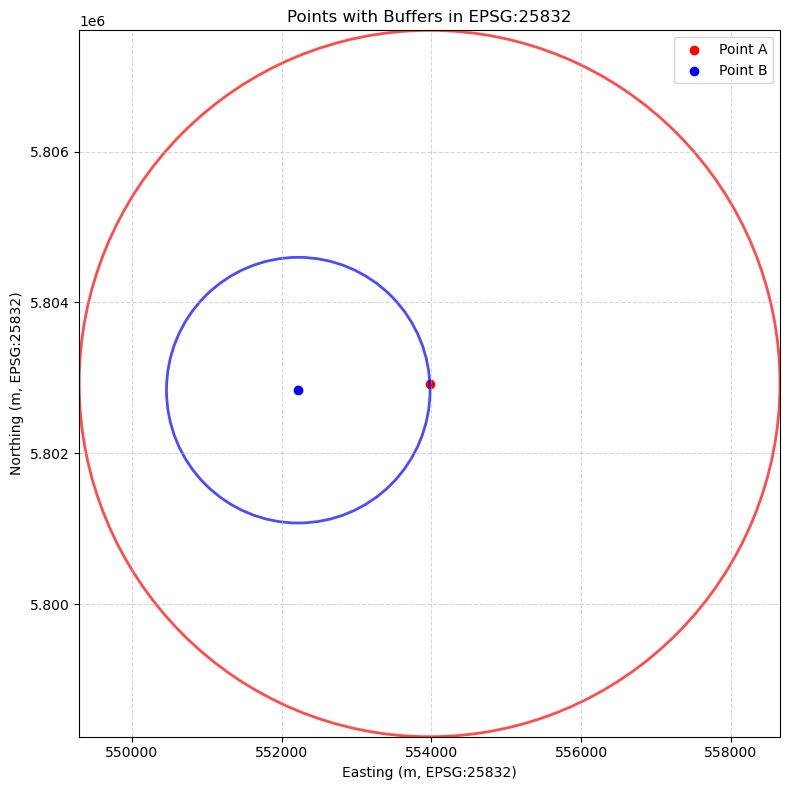

In [28]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

# Given coordinates and radii
xA, yA = 553974.57860439, 5802925.60509337
xB, yB = 552220.91668614, 5802837.50039429

radius_A = 4680.0
radius_B = 1760.0

# Create a new figure and axis
fig, ax = plt.subplots(figsize=(8, 8))

# Plot the points
ax.scatter([xA], [yA], color='red', label='Point A')
ax.scatter([xB], [yB], color='blue', label='Point B')

# Add circles (buffers) around the points
circleA = Circle((xA, yA), radius=radius_A, edgecolor='red', facecolor='none', linewidth=2, alpha=0.7)
circleB = Circle((xB, yB), radius=radius_B, edgecolor='blue', facecolor='none', linewidth=2, alpha=0.7)
ax.add_patch(circleA)
ax.add_patch(circleB)

# Adjust the plot view so both points and circles are visible
# Determine min and max extents by considering the outer boundaries of the largest circle
min_x = min(xA - radius_A, xB - radius_B)
max_x = max(xA + radius_A, xB + radius_B)
min_y = min(yA - radius_A, yB - radius_B)
max_y = max(yA + radius_A, yB + radius_B)

ax.set_xlim(min_x, max_x)
ax.set_ylim(min_y, max_y)

# Add grid and legend for clarity
ax.grid(True, linestyle='--', alpha=0.5)
ax.legend()

# Add labels
ax.set_xlabel('Easting (m, EPSG:25832)')
ax.set_ylabel('Northing (m, EPSG:25832)')
ax.set_title('Points with Buffers in EPSG:25832')

# Show the plot
plt.tight_layout()
plt.show()


In [41]:
Mid = pd.read_csv(r"C:\Users\petre\Documents\GitHub\MATSimPipeline\data\mid\enhanced\enhanced_mid.csv")
# show the col km_routing and wegkm_imp
# Mid = Mid[Mid['etapkm'] < 1000]
Mid[['km_routing', 'wegkm', 'wegkm_imp', 'etapkm', 'W_ZWECK', 'hvm']]

,km_routing,wegkm,wegkm_imp,etapkm,W_ZWECK,hvm
0,216.420,0.95,0.95,10107.0,4.0,4.0
1,216.419,1.43,1.43,10107.0,8.0,4.0
2,9995.000,10.45,10.45,10107.0,7.0,4.0
3,9995.000,7.60,7.60,10107.0,8.0,4.0
4,9995.000,13.30,13.30,10107.0,4.0,4.0
...,...,...,...,...,...,...
957009,70706.000,0.98,0.98,10107.0,1.0,2.0
957010,70706.000,0.98,0.98,10107.0,4.0,2.0
957011,70706.000,0.98,0.98,10107.0,8.0,2.0
957012,24.906,18.00,18.00,10107.0,7.0,5.0


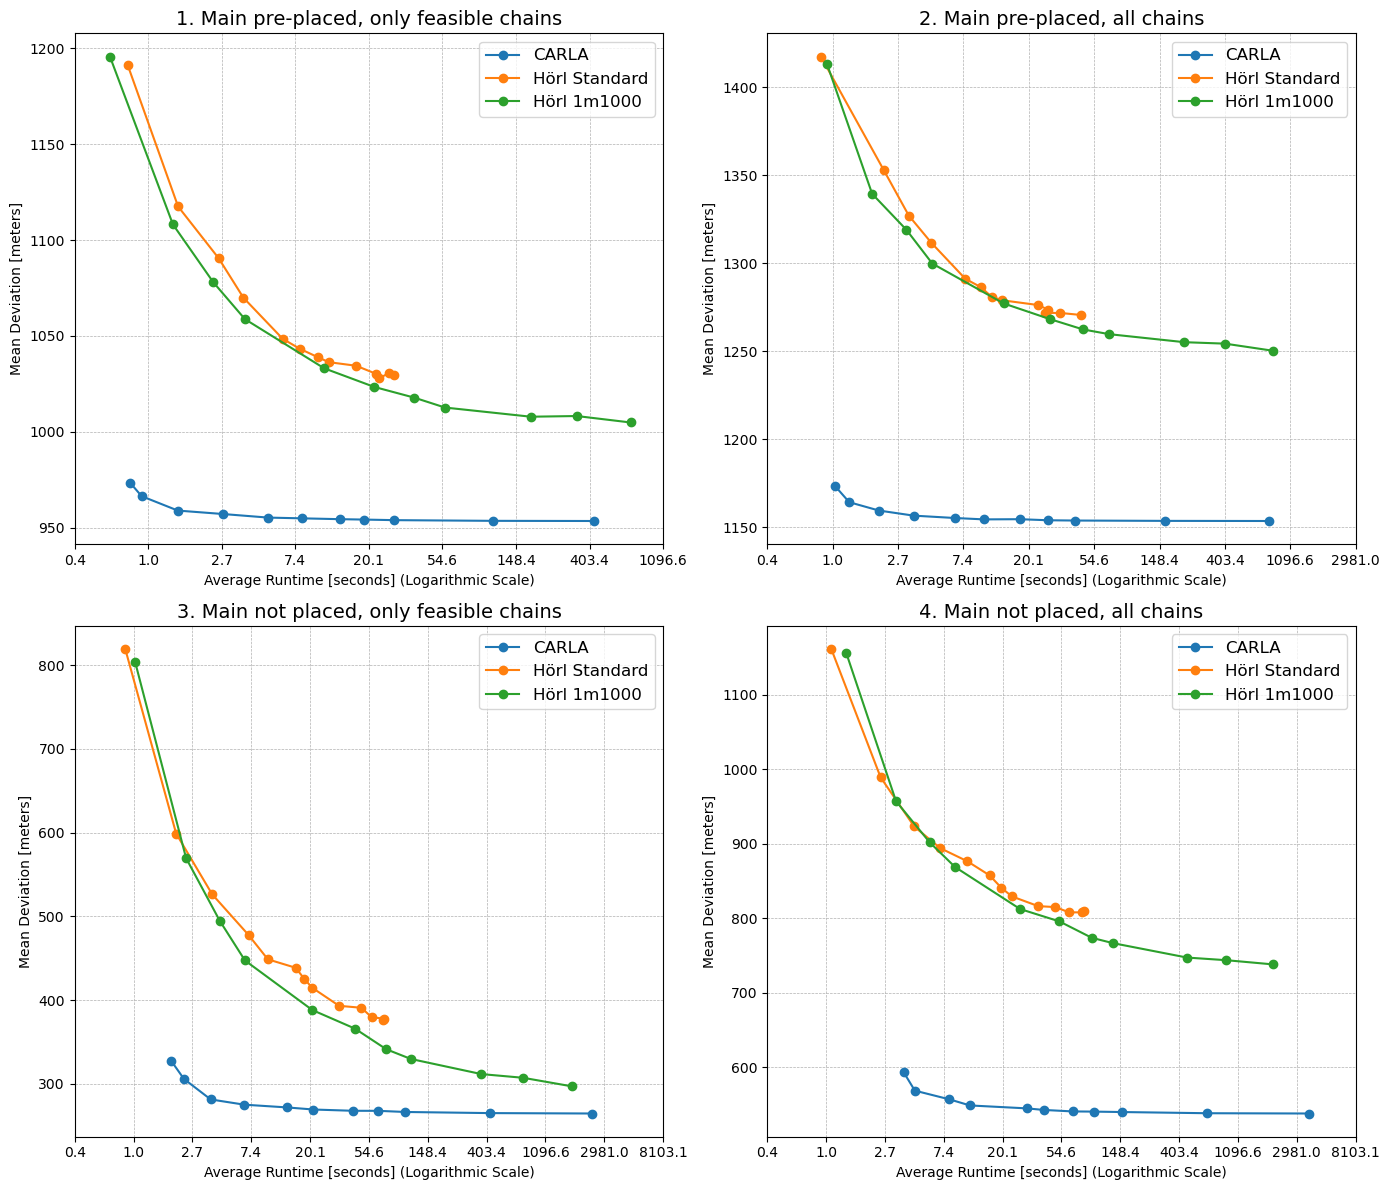

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# File paths
base_path = r"C:\Users\petre\Documents\GitHub\MATSimPipeline\analysis\analysis_data"
file_paths = {
    "onlyvalidmainplaced_hoerl_standard": os.path.join(base_path, "onlyvalidmainplaced_hoerl_standard.csv"),
    "onlyvalidmainplaced_hoerl_1m1000": os.path.join(base_path, "onlyvalidmainplaced_hoerl_1m1000.csv"),
    "onlyvalidmainplaced_petre": os.path.join(base_path, "onlyvalidmainplaced_petre.csv"),
    "invalidandvalidmainplaced_hoerl_standard": os.path.join(base_path, "invalidandvalidmainplaced_hoerl_standard.csv"),
    "invalidandvalidmainplaced_hoerl_1m1000": os.path.join(base_path, "invalidandvalidmainplaced_hoerl_1m1000.csv"),
    "invalidandvalidmainplaced_petre": os.path.join(base_path, "invalidandvalidmainplaced_petre.csv"),
    "onlyvalidmainandopenunplaced_hoerl_standard": os.path.join(base_path,
                                                                "onlyvalidmainandopenunplaced_hoerl_standard.csv"),
    "onlyvalidmainandopenunplaced_hoerl_1m1000": os.path.join(base_path,
                                                              "onlyvalidmainandopenunplaced_hoerl_1m1000.csv"),
    "onlyvalidmainandopenunplaced_petre": os.path.join(base_path, "onlyvalidmainandopenunplaced_petre.csv"),
    "invalidandvalidmainandopenunplaced_hoerl_std": os.path.join(base_path,
                                                                 "Invalidandvalidmainandopenunplaced_hoerl_std.csv"),
    "invalidandvalidmainandopenunplaced_hoerl_1m1000": os.path.join(base_path,
                                                                    "Invalidandvalidmainandopenunplaced_hoerl_1m1000.csv"),
    "invalidandvalidmainandopenunplaced_petre": os.path.join(base_path, "Invalidandvalidmainandopenunplaced_petre.csv"),
}

# Load data into DataFrames
dataframes = {name: pd.read_csv(path) for name, path in file_paths.items()}

# Organize datasets into the four combinations
combined_datasets = {
    "Placed & Only Valid": {
        "CARLA": dataframes.get("onlyvalidmainplaced_petre"),
        "Hörl Standard": dataframes.get("onlyvalidmainplaced_hoerl_standard"),
        "Hörl 1m1000": dataframes.get("onlyvalidmainplaced_hoerl_1m1000"),
    },
    "Placed & Valid and Unvalid Combined": {
        "CARLA": dataframes.get("invalidandvalidmainplaced_petre"),
        "Hörl Standard": dataframes.get("invalidandvalidmainplaced_hoerl_standard"),
        "Hörl 1m1000": dataframes.get("invalidandvalidmainplaced_hoerl_1m1000"),
    },
    "Unplaced & Only Valid": {
        "CARLA": dataframes.get("onlyvalidmainandopenunplaced_petre"),
        "Hörl Standard": dataframes.get("onlyvalidmainandopenunplaced_hoerl_standard"),
        "Hörl 1m1000": dataframes.get("onlyvalidmainandopenunplaced_hoerl_1m1000"),
    },
    "Unplaced & Valid and Unvalid Combined": {
        "CARLA": dataframes.get("invalidandvalidmainandopenunplaced_petre"),
        "Hörl Standard": dataframes.get("invalidandvalidmainandopenunplaced_hoerl_std"),
        "Hörl 1m1000": dataframes.get("invalidandvalidmainandopenunplaced_hoerl_1m1000"),
    },
}

# Remove the very first value for all Hörl data
for combination, data in combined_datasets.items():
    for method in ["Hörl Standard", "Hörl 1m1000"]:
        if data.get(method) is not None:
            data[method] = data[method].iloc[1:]  # Exclude the first row

# Titles for each plot
titles = [
    "1. Main pre-placed, only feasible chains",
    "2. Main pre-placed, all chains",
    "3. Main not placed, only feasible chains",
    "4. Main not placed, all chains",
]

# Plot the four cases in a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for i, (combination, data) in enumerate(combined_datasets.items()):
    ax = axes[i]
    for method, df in data.items():
        if df is not None:
            if method == "CARLA":
                # Filter Petre data to include only the "number_of_branches" parameter
                df = df[df["param"].str.contains("number_of_branches")]
            if not df.empty:
                x = df["average_runtime"]
                y = df["mean_quality"]
                # Plot both line and points
                ax.plot(
                    np.log(x),
                    y,
                    label=f"{method}",  # Customizable legend labels
                    linestyle="-",
                    marker="o",
                )
    ax.set_title(titles[i], fontsize=14)
    ax.set_xlabel("Average Runtime [seconds] (Logarithmic Scale)")
    ax.set_ylabel("Mean Deviation [meters]")  # Custom y-axis label
    # Set x-ticks to actual runtimes in seconds
    x_ticks = ax.get_xticks()
    ax.set_xticks(x_ticks)
    ax.set_xticklabels([f"{np.exp(tick):.1f}" for tick in x_ticks])
    ax.grid(True, which="both", linestyle="--", linewidth=0.5)
    ax.legend(fontsize=12)

# Adjust layout for clarity
#plt.style.use('seaborn-whitegrid')
plt.tight_layout()
plt.savefig(r"C:\Users\petre\Documents\GitHub\MATSimPipeline\analysis\fullcomparison.pdf")
plt.show()


In [ ]:
# Detailed Comparison

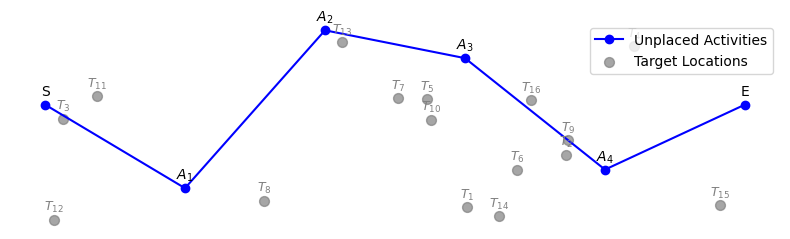

In [73]:
import matplotlib.pyplot as plt
import random

# Data for the trip chain
locations = ["S", r"$A_1$", r"$A_2$", r"$A_3$", r"$A_4$", "E"]
x_coords = [0, 1, 2, 3, 4, 5]  # Evenly spaced along the x-axis
y_coords = [0, -0.9, 0.8, 0.5, -0.7, 0]  # Reduced y for "Stop 1"

# Generate random target locations for plotting behind the trip chain
num_targets = 16  # Double the previous amount
target_x_coords = [random.uniform(0, 5) for _ in range(num_targets)]
target_y_coords = [random.uniform(-1.5, 1.5) for _ in range(num_targets)]
target_labels = [f"$T_{{{i + 1}}}$" for i in range(num_targets)]

# Plot the unplaced trip chain
plt.figure(figsize=(8, 2.5))
plt.plot(x_coords, y_coords, marker='o', linestyle='-', color='blue', label="Unplaced Activities")

# Plot target locations
plt.scatter(target_x_coords, target_y_coords, color='gray', s=50, alpha=0.7, label="Target Locations")
for i, (x, y) in enumerate(zip(target_x_coords, target_y_coords)):
    plt.text(x, y + 0.1, target_labels[i], fontsize=9, ha='center', color='gray')

# # Highlight "Stop 3" as the anchor location
# anchor_index = 3
# plt.scatter(x_coords[anchor_index], y_coords[anchor_index], color='red', s=100, label="Possible Anchor Location")

# Annotate points with location names
for i, location in enumerate(locations):
    plt.text(x_coords[i], y_coords[i] + 0.1, location, fontsize=10, ha='center')

# Formatting the plot
plt.xticks([])
plt.yticks([])
plt.legend(loc="upper right", fontsize=10)
plt.gca().set_frame_on(False)
plt.tight_layout()

# Save and display the plot
plt.savefig(r"C:\Users\petre\Documents\GitHub\MATSimPipeline\analysis\unplaced_trip_chain_with_more_targets.pdf")
plt.show()


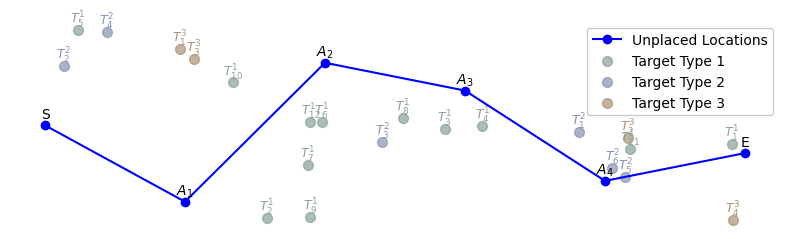

In [92]:
import matplotlib.pyplot as plt
import random

# Data for the trip chain
locations = ["S", r"$A_1$", r"$A_2$", r"$A_3$", r"$A_4$", "E"]
x_coords = [0, 1, 2, 3, 4, 5]  # Evenly spaced along the x-axis
y_coords = [0, -1.1, 0.9, 0.5, -0.8, -0.4]

# Generate random target locations for three types
num_targets = 12
target_types = {
    "Type 1": {
        "x_coords": [random.uniform(0, 5) for _ in range(num_targets)],
        "y_coords": [random.uniform(-1.5, 1.5) for _ in range(num_targets)],
        "color": "#88A295",  # Muted green-gray for Type 1

        "labels": [f"$T_{{{i + 1}}}^1$" for i in range(num_targets)],
    },
    "Type 2": {
        "x_coords": [random.uniform(0, 5) for _ in range(num_targets - 6)],
        "y_coords": [random.uniform(-1.5, 1.5) for _ in range(num_targets - 6)],
        "color": "#8793B0",  # Muted blue-gray for Type 2
        "labels": [f"$T_{{{i + 1}}}^2$" for i in range(num_targets - 6)],
    },
    "Type 3": {
        "x_coords": [random.uniform(0, 5) for _ in range(num_targets - 8)],
        "y_coords": [random.uniform(-1.5, 1.5) for _ in range(num_targets - 8)],
        "color": "#A89275",
        "labels": [f"$T_{{{i + 1}}}^3$" for i in range(num_targets - 8)],
    },
}

# Plot the unplaced trip chain
plt.figure(figsize=(8, 2.5))
plt.plot(x_coords, y_coords, marker='o', linestyle='-', color='blue', label="Unplaced Locations")

# Plot the target locations for each type
for target_type, data in target_types.items():
    plt.scatter(data['x_coords'], data['y_coords'], color=data['color'], s=50, alpha=0.7, label=f"Target {target_type}")
    for i, (x, y) in enumerate(zip(data['x_coords'], data['y_coords'])):
        plt.text(x, y + 0.1, data['labels'][i], fontsize=9, ha='center', color=data['color'])

# Annotate points with location names
for i, location in enumerate(locations):
    plt.text(x_coords[i], y_coords[i] + 0.1, location, fontsize=10, ha='center')

# Formatting the plot
plt.xticks([])
plt.yticks([])
plt.legend(loc="upper right", fontsize=10, framealpha=1)
plt.gca().set_frame_on(False)
plt.tight_layout()

# Save the plot
plt.savefig(r"C:\Users\petre\Documents\GitHub\MATSimPipeline\analysis\unplaced_trip_chain_with_target_types.pdf")
plt.show()

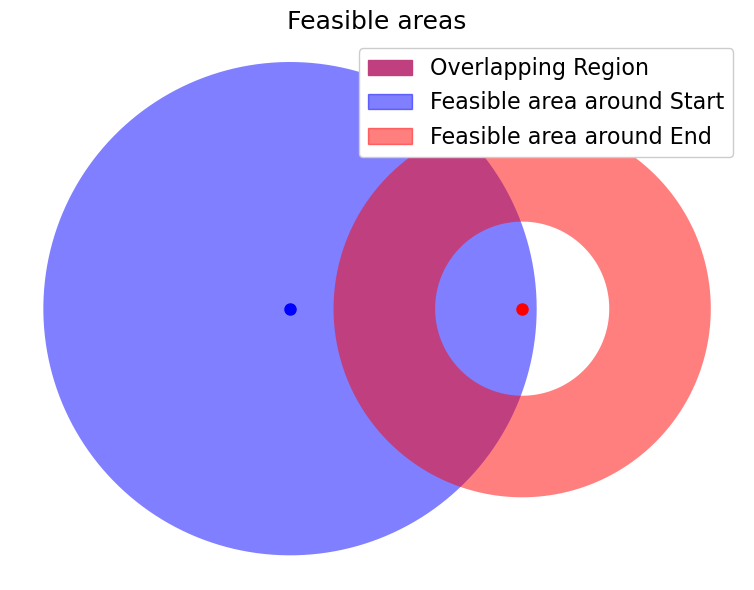

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.patches as mpatches


def plot_annulus(ax, center, r_inner, r_outer, color='blue', alpha=0.5):
    """
    Plot a smoother annulus (ring) using higher-resolution arcs.
    """
    theta = np.linspace(0, 2 * np.pi, 200)  # 200 points for smoothness

    # Outer circle
    x_outer = center[0] + r_outer * np.cos(theta)
    y_outer = center[1] + r_outer * np.sin(theta)

    # Inner circle (reversed)
    x_inner = center[0] + r_inner * np.cos(theta[::-1])
    y_inner = center[1] + r_inner * np.sin(theta[::-1])

    # Combine into a single path
    vertices = np.concatenate([np.column_stack([x_outer, y_outer]),
                               np.column_stack([x_inner, y_inner])])
    codes = ([mpath.Path.MOVETO] +
             [mpath.Path.LINETO] * (len(x_outer) - 1) +
             [mpath.Path.MOVETO] +
             [mpath.Path.LINETO] * (len(x_inner) - 1))

    path = mpath.Path(vertices, codes)
    patch = mpatches.PathPatch(path, facecolor=color, edgecolor='none', alpha=alpha)
    ax.add_patch(patch)


# --- PLOT FOR "ALREADY OVERLAPPING" SCENARIO ---

fig, ax = plt.subplots(figsize=(10, 6))

# Scenario details
location1 = np.array([0.0, 0.0])
location2 = np.array([16.0, 0.0])
r1a, r1b = 0.0, 17.0  # Inner and outer radii for ring 1
r2a, r2b = 6.0, 13.0  # Inner and outer radii for ring 2

ax.set_title("Feasible areas", fontsize=18)
ax.set_aspect('equal', 'box')

# Plot rings
plot_annulus(ax, location1, r1a, r1b, color='blue', alpha=0.5)
plot_annulus(ax, location2, r2a, r2b, color='red', alpha=0.5)

# Add dots and labels at the center of circles
ax.plot(location1[0], location1[1], 'o', color='blue', markersize=8, label="Start (S)")  # Blue dot
# ax.text(location1[0], location1[1] - 1, "S", color='blue', ha='center', fontsize=12)

ax.plot(location2[0], location2[1], 'o', color='red', markersize=8, label="End (E)")  # Red dot
# ax.text(location2[0], location2[1] - 1, "E", color='red', ha='center', fontsize=12)

# Create a legend to explain the overlapping region and start/end
overlap_patch = mpatches.Patch(color='#bf3f7f', alpha=1, label="Overlapping Region")
ax.legend(handles=[overlap_patch,
                   mpatches.Patch(color='blue', alpha=0.5, label="Feasible area around Start"),
                   mpatches.Patch(color='red', alpha=0.5, label="Feasible area around End")],
          loc="upper right", fontsize=16, framealpha=1, facecolor='white')

# Remove the distance line and label
# Set limits
# ax.set_xlim(-30, 30)
# ax.set_ylim(-30, 30)
ax.axis('off')  # Turn off axes for cleaner visualization

plt.tight_layout()
plt.savefig(r"C:\Users\petre\Documents\GitHub\MATSimPipeline\analysis\feasible_areas.pdf")
plt.show()


In [1]:
import pandas as pd

# Define the 20 columns to keep
columns_to_keep = [
    "H_ID", "H_GEW", "H_HOCH", "H_MIETE", "H_EINK",
    "hhgr_oecd", "oek_status", "anzauto_gr1", "anzrad_gr", "anzkind18",
    "anzwege1", "wegkm", "W_ZWECK", "W_AUTO_HH", "mobtyp",
    "wohnlage", "W_RADHELM", "W_ANZBEGL", "BLAND_GEO", "min_ozmz"
]

# Load the datasets
population_df = pd.read_csv(r"C:\Users\petre\Documents\GitHub\MATSimPipeline\analysis\population_with_buildings.csv")
enhanced_mid_df = pd.read_csv(r"C:\Users\petre\Documents\GitHub\MATSimPipeline\data\mid\enhanced\enhanced_mid.csv")

# Select only relevant columns and keep the first occurrence of each H_ID
filtered_mid_df = enhanced_mid_df[columns_to_keep].drop_duplicates(subset="H_ID")

# Perform a left merge to keep all household IDs from population_df
merged_df = pd.merge(population_df, filtered_mid_df, on="H_ID", how="left")

# Save the merged dataset
merged_df.to_csv("reduced_merged_population.csv", index=False)

# Inspect the merged dataset
print(merged_df.head())


C:\Users\petre\AppData\Local\Temp\ipykernel_10296\1525711536.py:12: DtypeWarning: Columns (3,6) have mixed types. Specify dtype option on import or set low_memory=False.
  population_df = pd.read_csv(r"C:\Users\petre\Documents\GitHub\MATSimPipeline\analysis\population_with_buildings.csv")


   household_id  STAAT  STADTTLNR BAUBLOCKNR     H_ID unique_household_id  \
0             1      1        1.0      11002  5608560           5608560_0   
1             2      1        1.0      11002  5985590           5985590_1   
2             3      1        1.0      11002  5988760           5988760_2   
3             4      1        1.0      11002  6026190           6026190_3   
4             5      1        1.0      11002  9444090           9444090_4   

                                            home_loc      H_GEW       H_HOCH  \
0  Point (549737.71100372297223657 5802894.652510...  11.764038  3080.746184   
1  Point (549737.71100372297223657 5802894.652510...   3.619289   947.813216   
2  Point (549737.71100372297223657 5802894.652510...  10.452667  2737.326714   
3  Point (549737.71100372297223657 5802894.652510...   4.434856  1161.392567   
4  Point (549737.71100372297223657 5802894.652510...   0.226827    59.401006   

   H_MIETE  ...  anzwege1     wegkm  W_ZWECK  W_AUTO_HH 

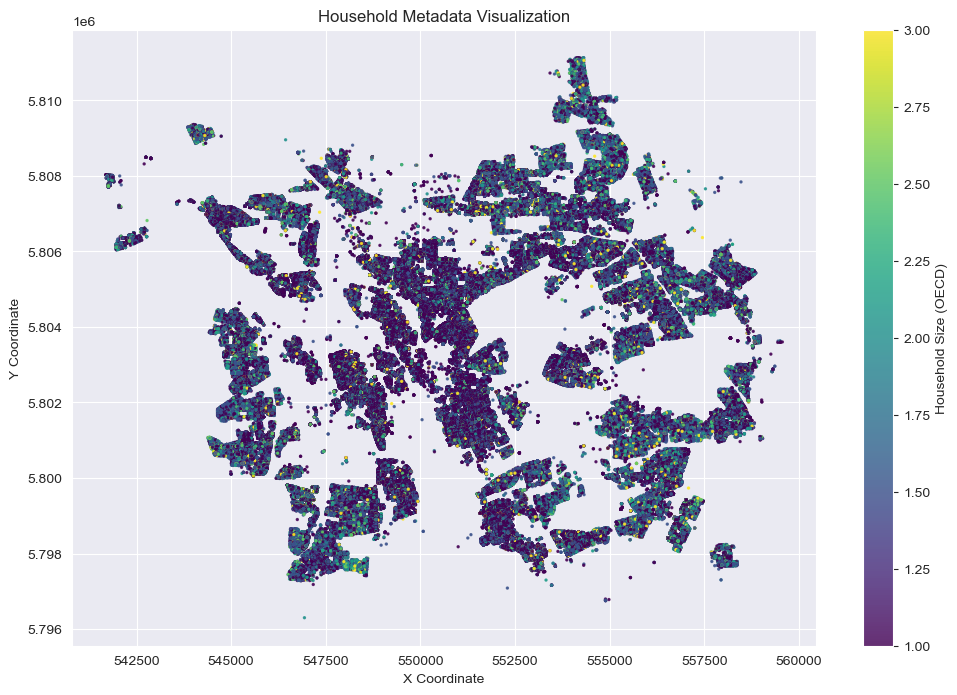

In [11]:
import matplotlib.pyplot as plt
import utils.helpers as h

# Extract x and y coordinates from Shapely Point
merged_df['home_loc'] = merged_df['home_loc'].apply(h.convert_to_point)
merged_df['x'] = merged_df['home_loc'].apply(lambda point: point.x if point else None)
merged_df['y'] = merged_df['home_loc'].apply(lambda point: point.y if point else None)

merged_df['hhgr_oecd_capped'] = merged_df['hhgr_oecd'].clip(upper=3)

# Plot households based on income (H_EINK) as color
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    merged_df['x'],
    merged_df['y'],
    c=merged_df['hhgr_oecd_capped'],  # Household income as color
    cmap='viridis',
    s=2,
    alpha=0.8
)
plt.colorbar(scatter, label='Household Size (OECD)')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Household Metadata Visualization')
plt.show()